提出问题
- 1.日PV有多少

- 2.日UV有多少

- 3.付费率情况如何

- 4.复购率是多少

- 5漏斗流失情况如何

- 6.用户价值情况

本数据集共有104万条左右数据，数据为淘宝APP2014年11月18日至2014年12月18日的用户行为数据，共计6列字段，列字段分别是：

user_id：用户身份，脱敏

item_id：商品ID，脱敏

behavior_type：用户行为类型（包含点击、收藏、加购物车、支付四种行为，分别用数字1、2、3、4表示）

user_geohash：地理位置

item_category：品类ID（商品所属的品类）

time：用户行为发生的时间

### 数据清洗

In [1]:
import pandas as pd
import numpy as py
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
data_user = pd.read_csv('tianchi_mobile_recommend_train_user.csv')

In [2]:
#缺失值处理
missingTotal = data_user.isnull().sum()
missingExist = missingTotal[missingTotal>0]
missingExist = missingExist.sort_values(ascending=False)

In [3]:
print(missingExist)

user_geohash    8334824
dtype: int64


In [4]:
print(missingTotal)

user_id                0
item_id                0
behavior_type          0
user_geohash     8334824
item_category          0
time                   0
dtype: int64


存在缺失值的是User_geohash，有717785条，不能删除缺失值，因为地理信息在数据集收集过程中做过加密转换，因此对数据集不做处理。

In [5]:
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [6]:
#一致化处理
import re
#拆分数据集
data_user['date'] = data_user['time'].map(lambda s: re.compile(' ').split(s)[0])

In [7]:
data_user['hour']=data_user['time'].map(lambda s:re.compile(' ').split(s)[1])
data_user.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,NaN,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21,2014-12-16,21


In [8]:
#查看data_user数据集数据类型：
data_user.dtypes

user_id           int64
item_id           int64
behavior_type     int64
user_geohash     object
item_category     int64
time             object
date             object
hour             object
dtype: object

In [9]:
#发现time列和date列应该转化为日期类数据类型，hour列应该是字符串数据类型。

#数据类型转化

data_user['date']=pd.to_datetime(data_user['date'])
data_user['time']=pd.to_datetime(data_user['time'])
data_user['hour']=data_user['hour'].astype('int64')
data_user.dtypes

user_id                   int64
item_id                   int64
behavior_type             int64
user_geohash             object
item_category             int64
time             datetime64[ns]
date             datetime64[ns]
hour                      int64
dtype: object

In [11]:
#异常值处理
data_user = data_user.sort_values(by='time',ascending=True)
data_user = data_user.reset_index(drop=True)
data_user.describe()

,user_id,item_id,behavior_type,item_category,hour
count,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07,1.225691e+07
mean,7.170732e+07,2.023084e+08,1.105271e+00,6.846162e+03,1.481799e+01
std,4.122920e+07,1.167397e+08,4.572662e-01,3.809922e+03,6.474778e+00
min,4.913000e+03,6.400000e+01,1.000000e+00,2.000000e+00,0.000000e+00
25%,3.584965e+07,1.014130e+08,1.000000e+00,3.721000e+03,1.000000e+01
50%,7.292804e+07,2.021359e+08,1.000000e+00,6.209000e+03,1.600000e+01
75%,1.073774e+08,3.035405e+08,1.000000e+00,1.029000e+04,2.000000e+01
max,1.424559e+08,4.045625e+08,4.000000e+00,1.408000e+04,2.300000e+01


通过观察数据集的四分位数，总数，平均值，方差等，发现数据集并无异常值存在。

### 用户行为分析（AARRR模型）

（1）pv和uv分析

PV(访问量)：即Page View, 具体是指网站的是页面浏览量或者点击量，页面被刷新一次就计算一次。

UV(独立访客)：即Unique Visitor,访问您网站的一台电脑客户端为一个访客。

1）日访问量分析

Text(0.5, 1.0, 'pv_daily')

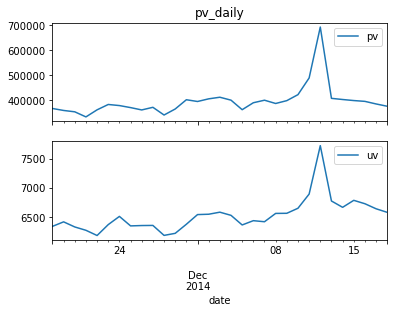

In [12]:
#pv_daily记录每天用户操作次数，uv_daily记录每天不同的上线用户数量
pv_daily=data_user.groupby('date')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
uv_daily=data_user.groupby('date')['user_id'].apply(lambda x:x.drop_duplicates().count()).reset_index().rename(columns={'user_id':'uv'})
fig,axes=plt.subplots(2,1,sharex=True)
pv_daily.plot(x='date',y='pv',ax=axes[0])
uv_daily.plot(x='date',y='uv',ax=axes[1])
axes[0].set_title('pv_daily')

结果显示如上图所示，在双十二期间，pv和uv访问量达到峰值，并且可以发现，uv和pv两个访问量数值差距比较大，同时，因为数据集总人数大约是10000人左右，因此，通过nv值可以分析出双十二期间淘宝用户的日活跃大概是45%浮动。

Text(0.5, 1.0, 'uv_hour')

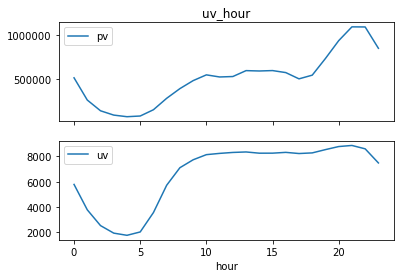

In [13]:
#小时访问量分析
#pv_hour记录每小时用户操作次数，uv_hour记录每小时不同的上线用户数量
pv_hour=data_user.groupby('hour')['user_id'].count().reset_index().rename(columns={'user_id':'pv'})
uv_hour=data_user.groupby('hour')['user_id'].apply(lambda x:x.drop_duplicates().count()).reset_index().rename(columns={'user_id':'uv'})
fig,axes=plt.subplots(2,1,sharex=True)
pv_hour.plot(x='hour',y='pv',ax=axes[0])
uv_hour.plot(x='hour',y='uv',ax=axes[1])
axes[0].set_title('pv_hour')
axes[0].set_title('uv_hour')

图表显示:pv和uv在凌晨0-5点期间波动情况相同，都呈下降趋势，访问量都比较小，同时在晚上18：00左右，pv波动情况比较剧烈，相比来看uv不太明显，因此晚上18：00以后是淘宝用户访问app的活跃时间段。

Text(0.5, 1.0, 'pv_different_behavior_type_except1')

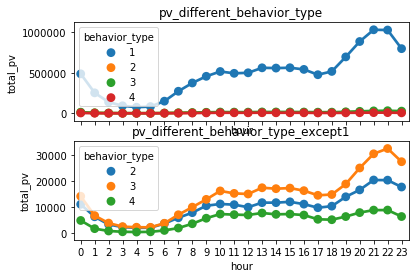

In [14]:
#不同行为类型用户pv分析
pv_detail=data_user.groupby(['behavior_type','hour'])['user_id'].count().reset_index().rename(columns={'user_id':'total_pv'})
fig,axes=plt.subplots(2,1,sharex=True)
sns.pointplot(x='hour',y='total_pv',hue='behavior_type',data=pv_detail,ax=axes[0])
sns.pointplot(x='hour',y='total_pv',hue='behavior_type',data=pv_detail[pv_detail.behavior_type!=1],ax=axes[1])
axes[0].set_title('pv_different_behavior_type')
axes[1].set_title('pv_different_behavior_type_except1')

有图表显示：点击这一用户行为相比较于其他三类用户行为，pv访问量较高，同时四种用户行为的波动情况基本一致，因此晚上这一时间段不管哪一种用户行为，pv访问量都是最高的。从图2可以看出，加入购物车这一用户行为的pv总量高于收藏的总量，因此在后续漏斗流失分析中，用户类型3应该在2之前分析。

### 用户消费行为分析

G:\anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


Text(0.5, 1.0, 'daily_user_buy')

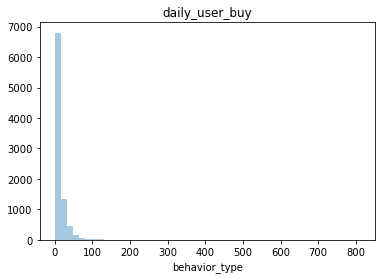

In [15]:
#（1）用户购买次数情况分析
data_user_buy=data_user[data_user.behavior_type==4].groupby('user_id')['behavior_type'].count()
sns.distplot(data_user_buy,kde=False)
plt.title('daily_user_buy')

图表显示：淘宝用户消费次数普遍在10次以内，因此需要重点关注购买次数在10次以上的消费者用户群体。

（2）日ARPPU

ARPPU（average revenue per paying user）是指从每位付费用户身上获得的收入，它反映的是每个付费用户的平均付费额度。

ARPPU=总收入/活跃用户付费数量

因为本数据集中没有消费金额，因此在计算过程中用消费次数代替消费金额

人均消费次数=消费总次数/消费人数

Text(0.5, 1.0, 'daily_ARPPU')

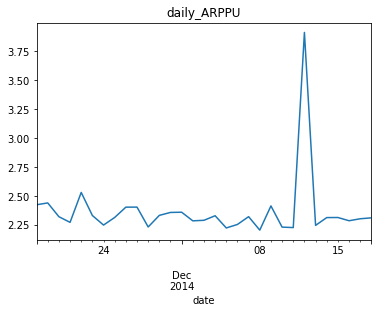

In [16]:
data_use_buy1=data_user[data_user.behavior_type==4].groupby(['date','user_id'])['behavior_type'].count().reset_index().rename(columns={'behavior_type':'total'})
data_use_buy1.groupby('date').apply(lambda x:x.total.sum()/x.total.count()).plot()
plt.title('daily_ARPPU')

图表显示：平均每天消费次数在1-2次之间波动，双十二期间消费次数达到最高值。

Text(0.5, 1.0, 'daily_ARPU')

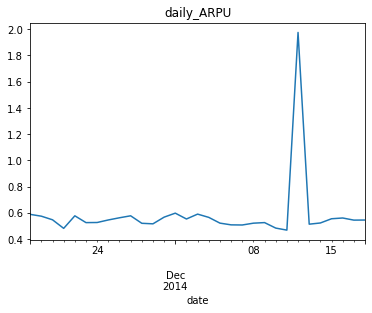

In [17]:
#（3）日ARPU

#ARPU(Average Revenue Per User) ：平均每用户收入，可通过 总收入/AU 计算得出。它可以衡量产品的盈利能力和发展活力。

#活跃用户数平均消费次数=消费总次数/活跃用户人数(每天有操作行为的为活跃)

data_user['operation']=1
data_use_buy2=data_user.groupby(['date','user_id','behavior_type'])['operation'].count().reset_index().rename(columns={'operation':'total'})
data_use_buy2.groupby('date').apply(lambda x:x[x.behavior_type==4].total.sum()/len(x.user_id.unique())).plot()
plt.title('daily_ARPU')

Text(0.5, 1.0, 'daily_afford_rate')

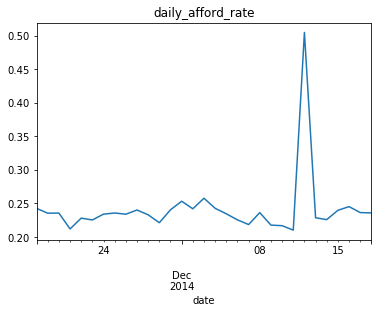

In [18]:
#（4）付费率

#付费率=消费人数/活跃用户人数

data_use_buy2.groupby('date').apply(lambda x:x[x.behavior_type==4].total.count()/len(x.user_id.unique())).plot()
plt.title('daily_afford_rate')

大多数用户消费：1次


G:\anaconda3\lib\site-packages\seaborn\distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


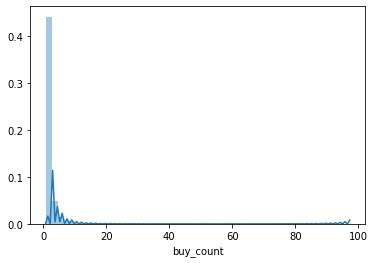

In [19]:
#（5）同一时间段用户消费次数分布

data_user_buy3=data_user[data_user.behavior_type==4].groupby(['user_id','date','hour'])['operation'].sum().rename('buy_count')
sns.distplot(data_user_buy3)
print('大多数用户消费：{}次'.format(data_user_buy3.mode()[0]))

In [20]:
#复购情况，即两天以上有购买行为,一天多次购买算一次
#复购率=有复购行为的用户数/有购买行为的用户总数

date_rebuy=data_user[data_user.behavior_type==4].groupby('user_id')['date'].apply(lambda x:len(x.unique())).rename('rebuy_count')
print('复购率:',round(date_rebuy[date_rebuy>=2].count()/date_rebuy.count(),4))

复购率: 0.8717


Text(0, 0.5, 'gap_count')

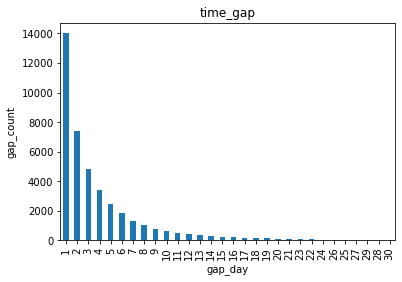

In [21]:
#所有复购时间间隔消费次数分布
data_day_buy=data_user[data_user.behavior_type==4].groupby(['user_id','date']).operation.count().reset_index()
data_user_buy4=data_day_buy.groupby('user_id').date.apply(lambda x:x.sort_values().diff(1).dropna())
data_user_buy4=data_user_buy4.map(lambda x:x.days)
data_user_buy4.value_counts().plot(kind='bar')
plt.title('time_gap')
plt.xlabel('gap_day')
plt.ylabel('gap_count')

多数用户复购率为0.4693，消费次数随着消费时间间隔的增加而不断下降，在1-10天之内复购次数比较多，10天之后复购次数淘宝用户很少在进行复购，因此需要重视10天之内的淘宝用户复购行为，增加用户复购。不同用户平均复购时间呈正态分布，但是总体来看，呈现逐渐下降趋势。多数淘宝用户平均复购时间集中在1-5天时间间隔内。

### 漏斗流失分析

漏斗分析是一套流程式数据分析，它能够科学反映用户行为状态以及从起点到终点各阶段用户转化率情况的重要分析模型

In [22]:
data_user_count=data_user.groupby(['behavior_type']).count()
data_user_count.head()
pv_all=data_user['user_id'].count()
print(pv_all)

12256906


In [23]:
#十、用户行为与商品种类关系分析

#不同用户行为类别的转化率
data_category=data_user[data_user.behavior_type!=2].groupby(['item_category','behavior_type']).operation.count().unstack(1).rename(columns={1:'点击量',3:'加入购物车量',4:'购买量'}).fillna(0)
data_category.head()

behavior_type,点击量,加入购物车量,购买量
item_category,,,
2,3.0,0.0,0.0
3,3.0,0.0,0.0
4,1.0,0.0,0.0
6,10.0,0.0,0.0
8,976.0,4.0,4.0
